<img src="images/sqlTables.png">


# Processamento 

###  Imports

 - psycopg2 : conexao com o postgresql no aws redshift
 - configparser : para carregar dados de acessao ao aws redshift.( Possui dados pessoais logo não estão mapeados no repositorio)
 - pandas: processamento dos dados

In [85]:
#!/usr/bin/python
import psycopg2
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import pandas as pd
from configparser import ConfigParser 
from datetime import datetime

### Ler do AWS Redshift os dados de clientes e pagamentos transformando em dataframe
Na medida do possivel foi processado os dados dentro do proprio banco, pois ele age de forma mais otimizada que localmente. 
Um exemplo desse é a query é a divisao do plano em duas partes, plano_tipo e plano_tempo

In [2]:
def config(filename='dbConfig.ini', section='postgresql'):
    # create a parser
    parser = ConfigParser()
    # read config file
    parser.read(filename)
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
    return db

def getDBs():
    conn = None
    try:
        params = config()
        conn = psycopg2.connect(**params)
        clientes_df = pd.read_sql("SELECT * FROM clientes", con=conn)
        pagamentos_query = "SELECT cliente_id, data, valor, split_part(plano, '/', 1) AS plano_tipo, split_part(plano, '/', 2) AS plano_tempo FROM pagamentos"
        pagamentos_df = pd.read_sql(pagamentos_query,con=conn)
        return clientes_df, pagamentos_df
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

In [3]:
clientes_df, pagamentos_df = getDBs()

In [4]:
c_df = clientes_df.copy() 
c_df.head()

,cliente_id,nome,cidade,estado,segmento
0,0,Empresa 0,Catarina,CE,Confecção / Textil
1,1,Empresa 1,Saboeiro,CE,Confecção / Textil
2,2,Empresa 2,Valentim Gentil,SP,Outro
3,3,Empresa 3,Barreirinha,AM,Informática
4,4,Empresa 4,Araporã,MG,Informática


In [5]:
pag_df = pagamentos_df.copy()
pag_df.head()

,cliente_id,data,valor,plano_tipo,plano_tempo
0,4683,2017-06-01,2394.00,Platina,6
1,2871,2017-09-01,600.00,Bronze,6
2,2578,2018-09-01,600.00,Bronze,6
3,1889,2019-05-01,250.00,Ouro,1
4,4297,2016-11-01,100.00,Bronze,1


In [6]:
print(c_df.info())
print('-'*50)
print(pag_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
cliente_id    5000 non-null int64
nome          5000 non-null object
cidade        5000 non-null object
estado        5000 non-null object
segmento      5000 non-null object
dtypes: int64(1), object(4)
memory usage: 195.4+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95476 entries, 0 to 95475
Data columns (total 5 columns):
cliente_id     95476 non-null int64
data           95476 non-null object
valor          95476 non-null object
plano_tipo     95476 non-null object
plano_tempo    95476 non-null object
dtypes: int64(1), object(4)
memory usage: 3.6+ MB
None


### Processar os dados lidos e transformar nos tipos adequados

Data transformado em Datetime
Plano_meses e valor transforamdo em numeros para utilizar em calculos

In [7]:
# Transforma data em datetime e remove o dia
pag_df['data'] = pag_df['data'].apply(pd.to_datetime)

# separa o plano em tipo de plano e tempo pago
pag_df['plano_tempo'] = pag_df['plano_tempo'].apply(pd.to_numeric)

#Remove o 'R$ ' e converte para numerico
pag_df['valor'] = pag_df['valor'].apply(pd.to_numeric)


In [8]:
pag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95476 entries, 0 to 95475
Data columns (total 5 columns):
cliente_id     95476 non-null int64
data           95476 non-null datetime64[ns]
valor          95476 non-null float64
plano_tipo     95476 non-null object
plano_tempo    95476 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.6+ MB


### Gerar uma tabela nova com dados completos. Baseado na tablea 2 do desafio

<img src="images/table_exemp2.png">

In [9]:
base_columns=['cliente_id', 'mes', 'valor']

In [10]:
# Como o pagamento e relativo ao tempo_de_plano e tipo_de plano, 
# cada pagamento e distribuido em valor_do_plano/tempo_do_plano
# logo se foi pago em janeiro 3 meses, é dividido o total do valor para janeiro, fevereiro e marco
def distribuir_pagamentos(pagamento):
    valor_mensal = pagamento['valor']/pagamento['plano_tempo']
    tempo_de_plano = pagamento['plano_tempo']
    meses = []    
    # para dividir cada pagamento e utilizado o mes em que foi realizado + tempo_de_plano
    # e adicionado em uma lista para depois adicionar em um dataframe (para ser mais facil de trabalhar)
    for i in range(tempo_de_plano):
        mes = pagamento['data'] + pd.tseries.offsets.DateOffset(months=i) 
        meses.append((pagamento['cliente_id'],mes,valor_mensal))
    return pd.DataFrame(meses,columns=base_columns)

In [11]:
# Para cada pagamento lido do DB eh distribuido entao o valor totam em parcelas para cada mes.
# Então esse pagamento distribuido e adicionado em um dataframe (todos_pagamentos_distibuido) contendo tudo
todos_pagamentos_distibuido = pd.DataFrame(columns=base_columns)
for index, pagamento in pag_df.iterrows():
    pag_distribuido = distribuir_pagamentos(pagamento)
    todos_pagamentos_distibuido = todos_pagamentos_distibuido.append(pag_distribuido,ignore_index=True)
    if index %5000 == 0:
        print(index,' / ', len(pag_df))
print("*Done*")
# ordena o dataframe por cliente_id e dentro de cada cliente pela data 
todos_pagamentos_distibuido.sort_values(by=['cliente_id','mes'],inplace=True)

0  /  95476
5000  /  95476
10000  /  95476
15000  /  95476
20000  /  95476
25000  /  95476
30000  /  95476
35000  /  95476
40000  /  95476
45000  /  95476
50000  /  95476
55000  /  95476
60000  /  95476
65000  /  95476
70000  /  95476
75000  /  95476
80000  /  95476
85000  /  95476
90000  /  95476
95000  /  95476
*Done*


In [167]:
todos_pagamentos_distibuido.sample(20)

,cliente_id,mes,valor
112068,0,2016-09-01,100.0
160364,0,2016-10-01,100.0
83245,0,2016-11-01,100.0
83246,0,2016-12-01,100.0
83247,0,2017-01-01,100.0
55778,0,2017-02-01,100.0
55779,0,2017-03-01,100.0
55780,0,2017-04-01,100.0
142936,0,2017-05-01,100.0
80059,0,2017-06-01,100.0


In [13]:
# Verifica qual as datas do primeiro e do ultimo pagamento realizado ( independente de quem realizou)
primeiro_mes = todos_pagamentos_distibuido['mes'].min()
ultimo_mes = todos_pagamentos_distibuido['mes'].max()

# Gerado um dataframe o qual o index é todos os 'anos-mes' entre o primeiro e o ultimo pagamento
# Ele sera usado para preencher meses em que um cliente nao pagou. 
all_dates_columns = ['mes']
all_dates = pd.DataFrame(columns=all_dates_columns)
all_dates['mes'] = pd.period_range(primeiro_mes,ultimo_mes, freq='M')
all_dates.set_index('mes',inplace = True)
all_dates.index.to_series().astype(str)
print(all_dates)


Empty DataFrame
Columns: []
Index: [2016-09, 2016-10, 2016-11, 2016-12, 2017-01, 2017-02, 2017-03, 2017-04, 2017-05, 2017-06, 2017-07, 2017-08, 2017-09, 2017-10, 2017-11, 2017-12, 2018-01, 2018-02, 2018-03, 2018-04, 2018-05, 2018-06, 2018-07, 2018-08, 2018-09, 2018-10, 2018-11, 2018-12, 2019-01, 2019-02, 2019-03, 2019-04, 2019-05, 2019-06, 2019-07, 2019-08, 2019-09, 2019-10, 2019-11, 2019-12]


In [14]:
all_dates.index

PeriodIndex(['2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
             '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
             '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
             '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
             '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', name='mes', freq='M')

In [15]:
# Rebece como parametro, todos os pagamentos conhecidos de um cliente e o ID dele
# Preenche todos os meses em que ele nao pagou com 'zero'
def verifica_pagamentos(pagamentos_cliente,cliente_id):
    todos_meses_cliente = all_dates.copy()
    todos_meses_cliente['cliente_id'] = cliente_id
    todos_meses_cliente['valor'] = 0
    for index,row in pagamentos_cliente.iterrows():
        data_pagamento = row['mes'].to_period('M').strftime('%F-%m')
        todos_meses_cliente.at[data_pagamento,'valor'] = row['valor']
    todos_meses_cliente.reset_index(inplace=True)
    
    return todos_meses_cliente


In [16]:
# cria um dataframe (todos_meses_df) nele e inserido todos acontecimentos de todos clientes
# se o cliente pagou ou nao eh indiferente, ele eh inserido neste dataframe
# dataframe semelhante a tabela 2 disposta no desafio
todos_meses_df = pd.DataFrame(columns=base_columns)
clientes_existentes = todos_pagamentos_distibuido['cliente_id'].unique()
for cliente_id in sorted(clientes_existentes):
    pagamentos_realizados_cliente = todos_pagamentos_distibuido[todos_pagamentos_distibuido['cliente_id'] == cliente_id]
    pagamentos_cliente = verifica_pagamentos(pagamentos_realizados_cliente,cliente_id)
    todos_meses_df = todos_meses_df.append(pagamentos_cliente,ignore_index=True)
    if cliente_id%200 == 0:
        print(cliente_id,'/',len(clientes_existentes))
print("*Done*")        

/home/ruancmoral/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0 / 5000
100 / 5000
200 / 5000
300 / 5000
400 / 5000
500 / 5000
600 / 5000
700 / 5000
800 / 5000
900 / 5000
1000 / 5000
1100 / 5000
1200 / 5000
1300 / 5000
1400 / 5000
1500 / 5000
1600 / 5000
1700 / 5000
1800 / 5000
1900 / 5000
2000 / 5000
2100 / 5000
2200 / 5000
2300 / 5000
2400 / 5000
2500 / 5000
2600 / 5000
2700 / 5000
2800 / 5000
2900 / 5000
3000 / 5000
3100 / 5000
3200 / 5000
3300 / 5000
3400 / 5000
3500 / 5000
3600 / 5000
3700 / 5000
3800 / 5000
3900 / 5000
4000 / 5000
4100 / 5000
4200 / 5000
4300 / 5000
4400 / 5000
4500 / 5000
4600 / 5000
4700 / 5000
4800 / 5000
4900 / 5000
*Done*


### Geração dos novos dados

   - Monthly Recurring Revenue - MRR: É o valor pago mensalmente por cada cliente. Importante: O valor do MRR deve respeitar o número de meses do plano. Ou seja, o pagamento de R\\$300,00 do plano Ouro/3 realizado em 15/01/2019 deve ser dividido entre os três meses de sua vigência, ficando R\\$ 100,00 em Jan/2019, R\\$ 100,00 em Fev/2019 e R\\$ 100,00 em Mar/2019.

In [17]:
def get_MRR(pagamentos_cliente,mes):
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    return pagamentos_cliente_indexado.loc[mes]['valor']

   - New MRR: É o valor pago por clientes que fizeram o primeiro pagamento no mês analisado.

In [18]:
def get_new_MRR(pagamentos_cliente,mes):
    mes_anterior = mes - pd.tseries.offsets.DateOffset(months=1)
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    valor_pago_anteriormente = pagamentos_cliente_indexado.loc[:mes_anterior]['valor'].sum()
    if valor_pago_anteriormente == 0.0:
        return pagamentos_cliente_indexado.loc[mes]['valor']
    else:
        return 0.0

- Expansion MRR: É a diferença entre o valor pago no mês atual e o valor pago no mês anterior por clientes que pagaram mais no mês atual do que no mês anterior.

In [19]:
def get_exp_MRR(pagamentos_cliente,mes):
    mes_anterior = mes - pd.tseries.offsets.DateOffset(months=1)
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    try:
        valor_anterior = pagamentos_cliente_indexado.loc[mes_anterior]['valor']
    except:
        valor_anterior = 0.0
    valor_corrente = pagamentos_cliente_indexado.loc[mes]['valor']
    if valor_anterior >= valor_corrente :
        return 0.0
    else:
        return valor_corrente - valor_anterior

- Contraction MRR: É a diferença entre o valor pago no mês atual e o valor pago no mês anterior por clientes que pagaram mais no mês anterior do que no mês analisado.

In [20]:
def get_con_MRR(pagamentos_cliente,mes):
    mes_anterior = mes - pd.tseries.offsets.DateOffset(months=1)
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    try:
        valor_anterior = pagamentos_cliente_indexado.loc[mes_anterior]['valor']
    except:
        valor_anterior = 0.0
    valor_corrente = pagamentos_cliente_indexado.loc[mes]['valor']
    if valor_anterior <= valor_corrente:
        return 0.0
    else:
        return valor_anterior - valor_corrente

   - Cancelled MRR: É valor pago no mês anterior ao analisado por clientes que não pagaram o mês analisado.

In [21]:
def get_can_MRR(pagamentos_cliente,mes):
    mes_anterior = mes - pd.tseries.offsets.DateOffset(months=1)
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    try:
        valor_anterior = pagamentos_cliente_indexado.loc[mes_anterior]['valor']
    except:
        valor_anterior = 0.0
    valor_corrente = pagamentos_cliente_indexado.loc[mes]['valor']
    if valor_corrente == 0.0:
        return valor_anterior
    else:
        return 0.0

   - Resurrected MRR: É o valor pago por clientes que não pagaram o mês anterior ao analisado, mas já tiveram um pagamento no passado e realizaram um novo pagamento no mês analisado.

In [22]:
def get_res_MRR(pagamentos_cliente,mes):
    mes_anterior = mes - pd.tseries.offsets.DateOffset(months=1)
    pagamentos_cliente_indexado  = pagamentos_cliente.set_index('mes')
    try:
        valor_anterior = pagamentos_cliente_indexado.loc[mes_anterior]['valor']
    except:
        valor_anterior = 0.0
    soma_anterior = pagamentos_cliente_indexado.loc[:mes_anterior]['valor'].sum()
    valor_corrente = pagamentos_cliente_indexado.loc[mes]['valor']
    if valor_anterior == 0.0 and soma_anterior != 0.0:
        return valor_corrente
    else:
        return 0.0

Criado um vetor com todas as metricas em um dado mes para cada cliente

In [23]:
def calcula_metricas(pagamentos_cliente,cliente_id,mes):
    dados = [cliente_id,mes.to_period('M').strftime('%F-%m'),
             get_MRR(pagamentos_cliente,mes),get_new_MRR(pagamentos_cliente,mes),
             get_exp_MRR(pagamentos_cliente,mes),get_con_MRR(pagamentos_cliente,mes),
             get_can_MRR(pagamentos_cliente,mes),get_res_MRR(pagamentos_cliente,mes)]
    metricas_cliente_mes = pd.DataFrame([dados],columns=metricas_columns)
    return metricas_cliente_mes

Iteração entre todos os cliente em todos os meses, criando um dataframe completo com uma analise completa
Esta celula é mais custosa computacionalmente

In [24]:
metricas_columns = ['cliente_id','mes','mrr','new_mrr','exp_mrr','con_mrr','can_mrr','res_mrr']
todas_metricas_df = pd.DataFrame(columns=metricas_columns)
periodo = pd.date_range(start=primeiro_mes, end=ultimo_mes,  freq='MS')
for cliente_id in sorted(todos_meses_df['cliente_id'].unique()):
    for mes in periodo:
        pagamentos_cliente = todos_meses_df[todos_meses_df['cliente_id'] == cliente_id]
        metrica = calcula_metricas(pagamentos_cliente,cliente_id,mes)
        todas_metricas_df = todas_metricas_df.append(metrica,ignore_index=True)
    if cliente_id%200 == 0:
        print(cliente_id,'/',len(todos_meses_df['cliente_id'].unique()))
print("*Done*")

0 / 5000
200 / 5000
400 / 5000
600 / 5000
800 / 5000
1000 / 5000
1200 / 5000
1400 / 5000
1600 / 5000
1800 / 5000
2000 / 5000
2200 / 5000
2400 / 5000
2600 / 5000
2800 / 5000
3000 / 5000
3200 / 5000
3400 / 5000
3600 / 5000
3800 / 5000
4000 / 5000
4200 / 5000
4400 / 5000
4600 / 5000
4800 / 5000
*Done*


In [25]:
# Celula anterior gera todas as metricas para todos meses e clientes, logo é custosa para se calcular 
# Foi entao salvo os dados em um CSV para acessar sem precisar recalcular a todo instante
todas_metricas_df.to_csv('CSVs/todas_metricas.csv',index=False)
todas_metricas_df = pd.read_csv('CSVs/todas_metricas.csv')
todas_metricas_df.sample(20)

,cliente_id,mes,mrr,new_mrr,exp_mrr,con_mrr,can_mrr,res_mrr
196692,4917,2017-09,0.0,0.0,0.0,0.0,0.0,0.0
108792,2719,2019-05,185.0,0.0,0.0,0.0,0.0,0.0
182955,4573,2019-08,185.0,0.0,0.0,0.0,0.0,0.0
68715,1717,2019-08,100.0,0.0,0.0,0.0,0.0,0.0
140564,3514,2017-01,100.0,0.0,0.0,0.0,0.0,0.0
71957,1798,2019-10,250.0,0.0,0.0,0.0,0.0,0.0
190201,4755,2016-10,185.0,0.0,0.0,0.0,0.0,0.0
122206,3055,2017-03,185.0,0.0,0.0,0.0,0.0,0.0
122562,3064,2016-11,250.0,0.0,250.0,0.0,0.0,250.0
91916,2297,2019-09,185.0,0.0,0.0,0.0,0.0,0.0


# Analise

In [29]:
# Agrupar todos os cliente em grupos de segmento e estado. 
clientes_groups = c_df.groupby(['segmento','estado'])['cliente_id'].apply(list).reset_index(name='ids')

In [226]:
todas_metricas_df.head(20)

,cliente_id,mes,mrr,new_mrr,exp_mrr,con_mrr,can_mrr,res_mrr
0,0,2016-09,100.0,100.0,100.0,0.0,0.0,0.0
1,0,2016-10,100.0,0.0,0.0,0.0,0.0,0.0
2,0,2016-11,100.0,0.0,0.0,0.0,0.0,0.0
3,0,2016-12,100.0,0.0,0.0,0.0,0.0,0.0
4,0,2017-01,100.0,0.0,0.0,0.0,0.0,0.0
5,0,2017-02,100.0,0.0,0.0,0.0,0.0,0.0
6,0,2017-03,100.0,0.0,0.0,0.0,0.0,0.0
7,0,2017-04,100.0,0.0,0.0,0.0,0.0,0.0
8,0,2017-05,100.0,0.0,0.0,0.0,0.0,0.0
9,0,2017-06,100.0,0.0,0.0,0.0,0.0,0.0


In [258]:
# Adiciona coluna 'segmento' e 'estado' dentro do dataframa 'todas_metricas_df'
# Todas_metricas_df possui o calculo de todas as metricas SaaS em todos os meses de todos os clientes.
# Adicionado neste dataframe para melhor agrupar os dados para analise

metricas_base_columns = ['segmento','mes','mrr','new_mrr','exp_mrr','con_mrr','can_mrr','res_mrr']
metricas_analises_df = pd.DataFrame(columns=metricas_base_columns)

for cli in range(len(clientes_groups)):
    metricas = todas_metricas_df[todas_metricas_df['cliente_id'].isin(clientes_groups.loc[cli]['ids'])].groupby('mes').sum()
    metricas['segmento'] = clientes_groups.loc[cli]['segmento']
    metricas['estado'] = clientes_groups.loc[cli]['estado']
    metricas = metricas.reset_index('mes')
    metricas.drop(columns='cliente_id',inplace=True)
    
    metricas_analises_df = metricas_analises_df.append(metricas,ignore_index=True)
    if cli%50==0:
        print(cli,'/',len(clientes_groups))
print("*Done*")


/home/ruancmoral/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0 / 442
50 / 442
100 / 442
150 / 442
200 / 442
250 / 442
300 / 442
350 / 442
400 / 442
*Done*


In [388]:
metricas_analises_df.sample(20)

,can_mrr,con_mrr,estado,exp_mrr,mes,mrr,new_mrr,res_mrr,segmento
4025,0.0,0.0,MT,0.0,2018-10,2269.0,0.0,0.0,Confecção / Textil
6088,0.0,0.0,PE,399.0,2017-05,499.0,0.0,399.0,Decoração / Cama / Mesa / Banho
4765,0.0,0.0,CE,0.0,2017-02,3187.0,0.0,0.0,Cosméticos / Perfumaria / Higiene
2459,0.0,0.0,RS,100.0,2018-04,1219.0,0.0,100.0,Brinquedos
2463,0.0,0.0,RS,0.0,2018-08,1369.0,0.0,0.0,Brinquedos
473,185.0,185.0,MT,0.0,2019-06,7137.0,0.0,0.0,Alimentos / Bebida
16215,0.0,0.0,AP,0.0,2017-12,100.0,0.0,0.0,Utilidades
12308,0.0,0.0,PB,0.0,2019-01,350.0,0.0,0.0,Medicamentos
10384,0.0,149.0,MG,399.0,2018-09,2831.0,0.0,399.0,Limpeza / Higiene
12295,0.0,0.0,PB,0.0,2017-12,350.0,0.0,0.0,Medicamentos


In [261]:
# Removido dados com estado == uf. São clientes onde faltou adicionar este dado na api
metricas_analises_df = metricas_analises_df[metricas_analises_df.estado != 'uf']


# Meses de '2016-09' e '2016-10' foram os primeiros meses em que receberam pagamentos
# foram removidos para analise pois para analise como resurrected_MRR estavam gerando graficos distorcido
# Mesmo para os meses finais da amostragemm  ('2019-08','2019-09','2019-10','2019-11','2019-12)
# Nestes meses ainda nao existem pagamentos por serem dados atuais ou futuras que nao foram dispostas no
# arquivo de pagamentos.csv inicial.
remover_meses = ['2016-09','2016-10','2019-08','2019-09','2019-10','2019-11','2019-12']
metricas_analises_df = metricas_analises_df[~metricas_analises_df['mes'].isin(remover_meses)]
# metricas_analises_df_antigas = metricas_analises_df[metricas_analises_df.mes != '2016-09']

metricas_analises_df.head(10)

,can_mrr,con_mrr,estado,exp_mrr,mes,mrr,new_mrr,res_mrr,segmento
2,0.0,0.0,AC,0.0,2016-11,1768.0,0.0,0.0,Alimentos / Bebida
3,0.0,0.0,AC,0.0,2016-12,1768.0,0.0,0.0,Alimentos / Bebida
4,0.0,0.0,AC,0.0,2017-01,1768.0,0.0,0.0,Alimentos / Bebida
5,0.0,0.0,AC,0.0,2017-02,1768.0,0.0,0.0,Alimentos / Bebida
6,0.0,0.0,AC,0.0,2017-03,1768.0,0.0,0.0,Alimentos / Bebida
7,0.0,150.0,AC,0.0,2017-04,1618.0,0.0,0.0,Alimentos / Bebida
8,0.0,0.0,AC,0.0,2017-05,1618.0,0.0,0.0,Alimentos / Bebida
9,0.0,0.0,AC,0.0,2017-06,1618.0,0.0,0.0,Alimentos / Bebida
10,0.0,0.0,AC,0.0,2017-07,1618.0,0.0,0.0,Alimentos / Bebida
11,0.0,0.0,AC,0.0,2017-08,1618.0,0.0,0.0,Alimentos / Bebida


Verificar o MRR geral da empresa por ao longo dos meses

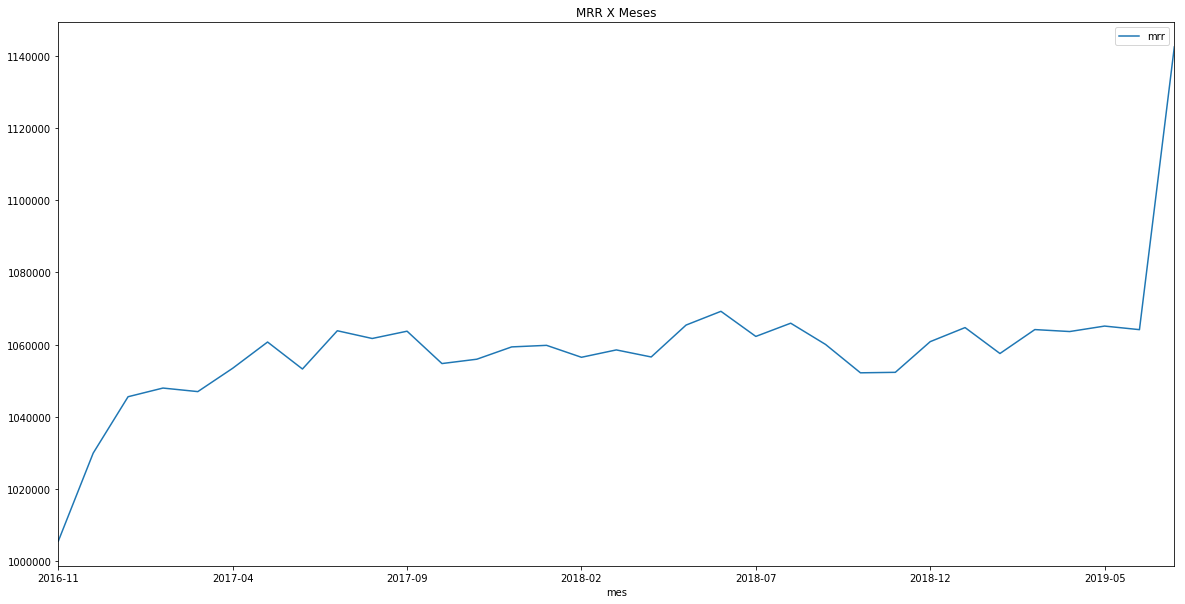

In [549]:
metricas_analises_df.groupby('mes')['mrr'].sum().plot(legend=True,title='MRR X Meses')

Estduando o MRR dos clientes por estado

Podemos observar os estados de concentração dos princiapis clientes( BA,PI,SP,MA,MG,RS)

De mesmo modo os estados mais fracos (RR,AP,ES,AC,AM,MS)

Podendo então tentar desenvolver melho o produto nestes estados onde possui baixo numero de clientes 

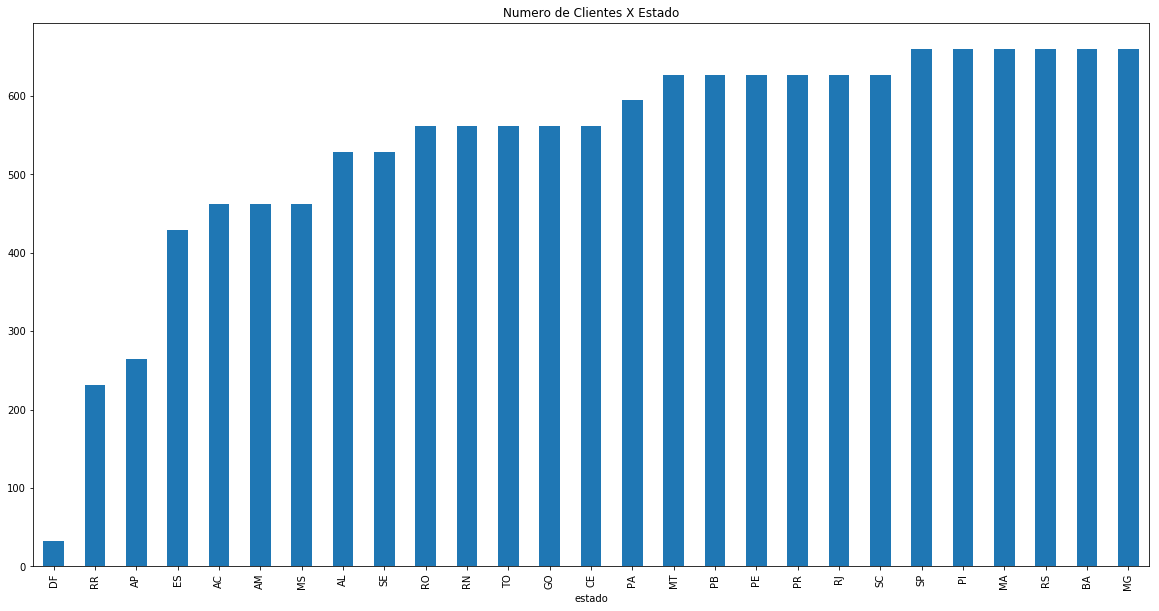

In [550]:
metricas_analises_df.groupby('estado')['mrr'].count().sort_values().plot(kind='bar',title='Numero de Clientes X Estado')


Verificando onde esta o principais clientes pagantes, valida-se a analise anterior

Os clientes que mais pagam ( MG,SP,BA,RS) são os mesmo que possuem mais clientes 

O mesmo pode ser dido para os que menos pagam ( RR,AP,AC,RO)

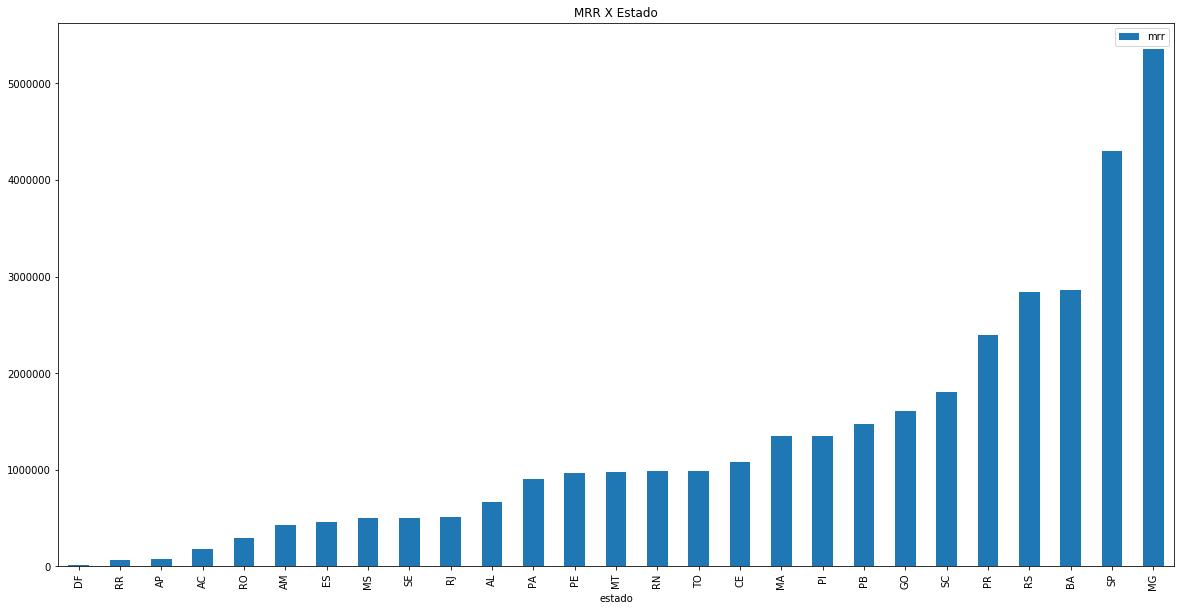

In [551]:
metricas_analises_df.groupby('estado')['mrr'].sum().sort_values().plot(kind='bar',legend=True,title='MRR X Estado')

Quantidade de clientes por segmento

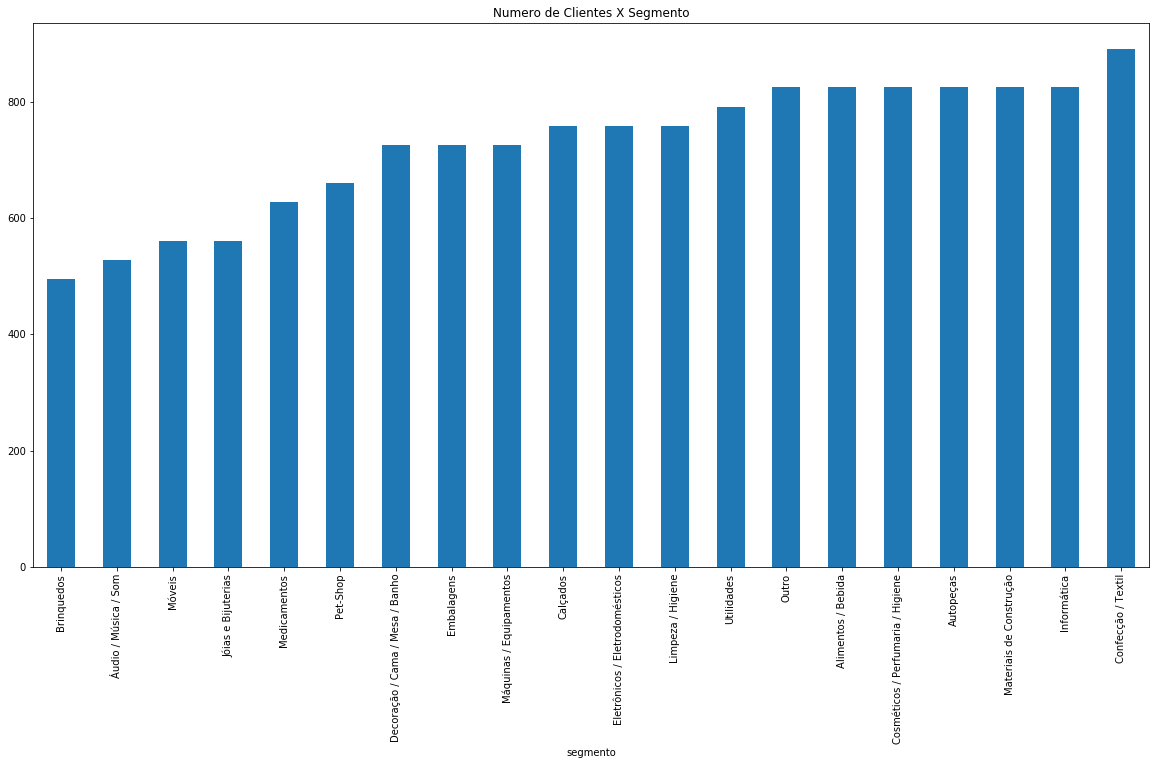

In [552]:
metricas_analises_df.groupby('segmento')['mrr'].count().sort_values().plot(kind='bar',title='Numero de Clientes X Segmento')

MRR total por segmento

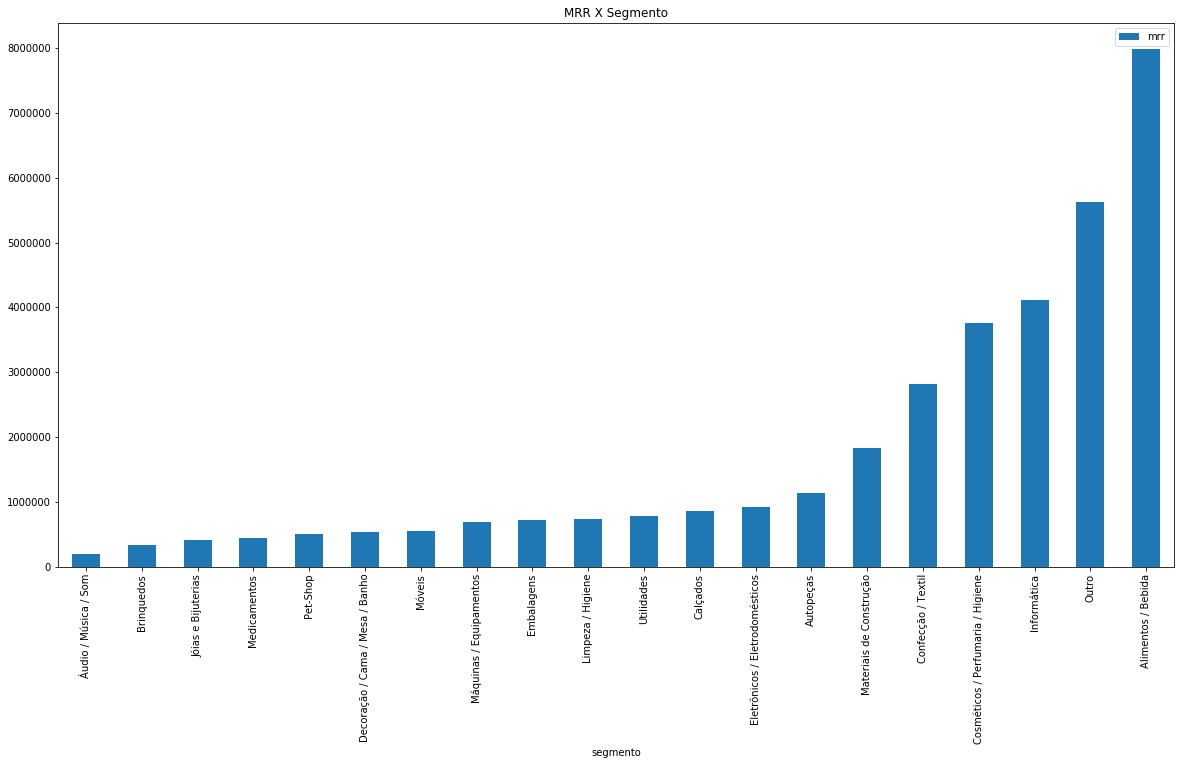

In [553]:
metricas_analises_df.groupby('segmento')['mrr'].sum().sort_values().plot(kind='bar',legend=True,title='MRR X Segmento')

Comparativo Resurrected MRR e Cancelled MRR por estado

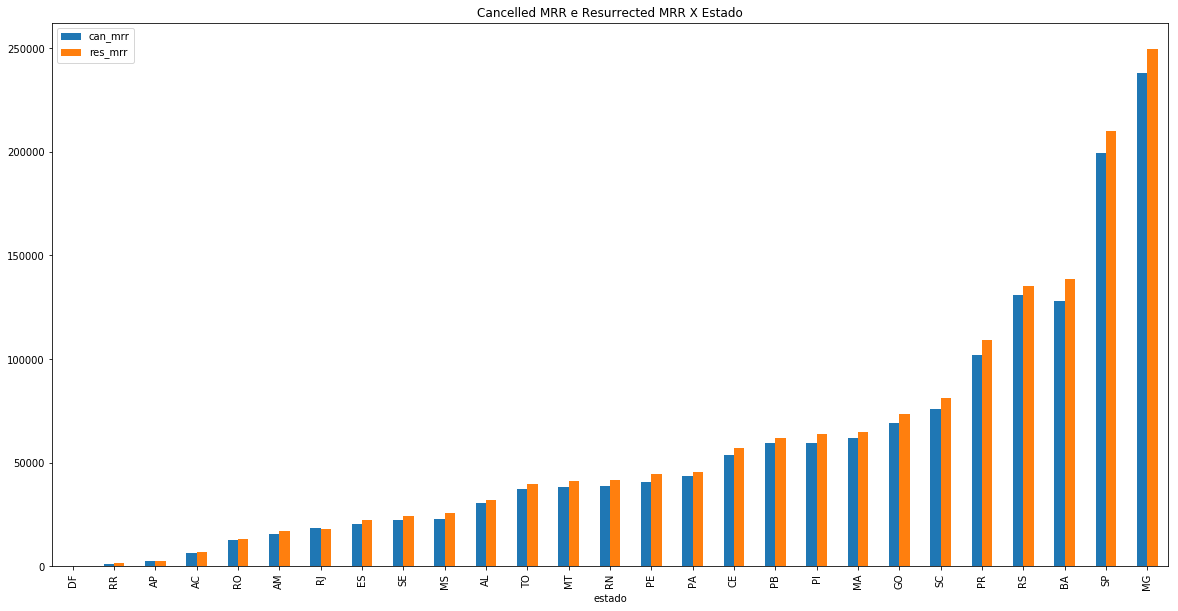

In [554]:
metricas_analises_df.groupby('estado')['can_mrr','res_mrr'].sum().sort_values(by='res_mrr').plot(kind='bar',legend=True,title='Cancelled MRR e Resurrected MRR X Estado')

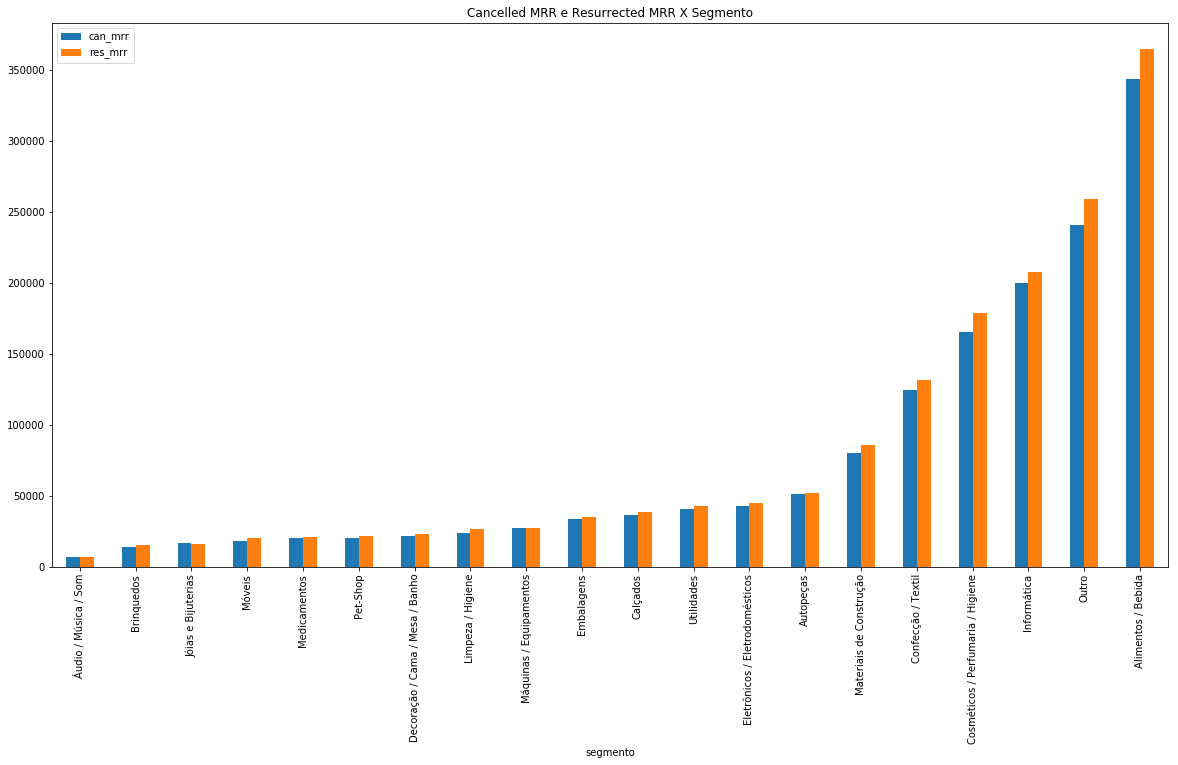

In [555]:
metricas_analises_df.groupby('segmento')['can_mrr','res_mrr'].sum().sort_values(by='res_mrr').plot(kind='bar',legend=True,title='Cancelled MRR e Resurrected MRR X Segmento')

Comparativo Expansion MRR e Contranctio MRR por estado

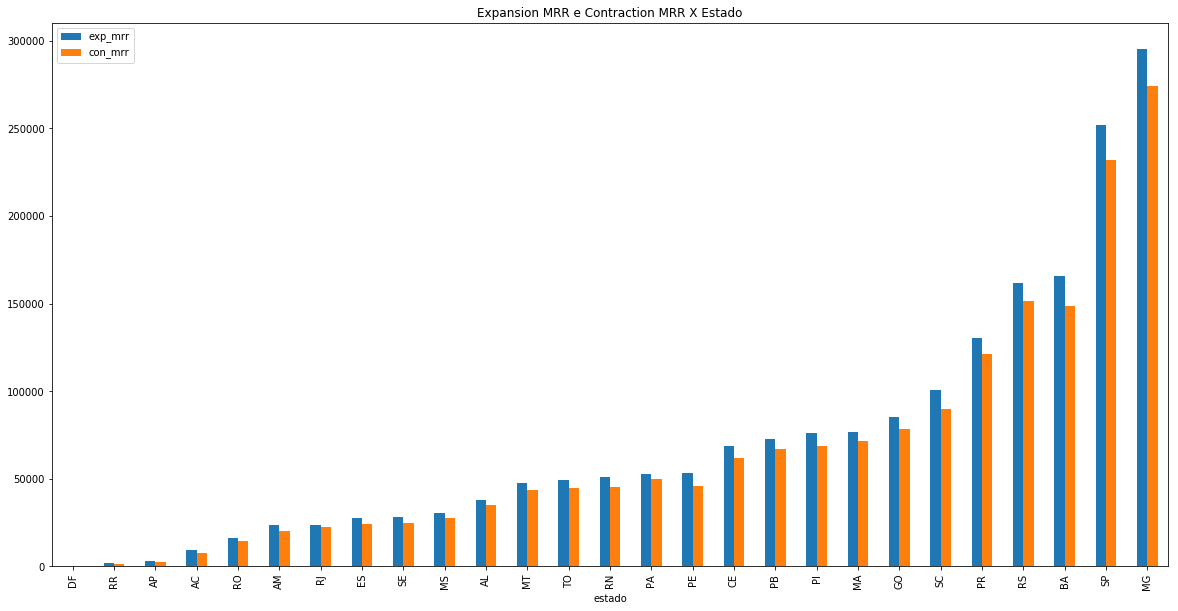

In [556]:
metricas_analises_df.groupby('estado')['exp_mrr','con_mrr'].sum().sort_values(by='exp_mrr').plot(kind='bar',legend=True,title='Expansion MRR e Contraction MRR X Estado')

Comparativo Expansion MRR e Contranctio MRR por segmento

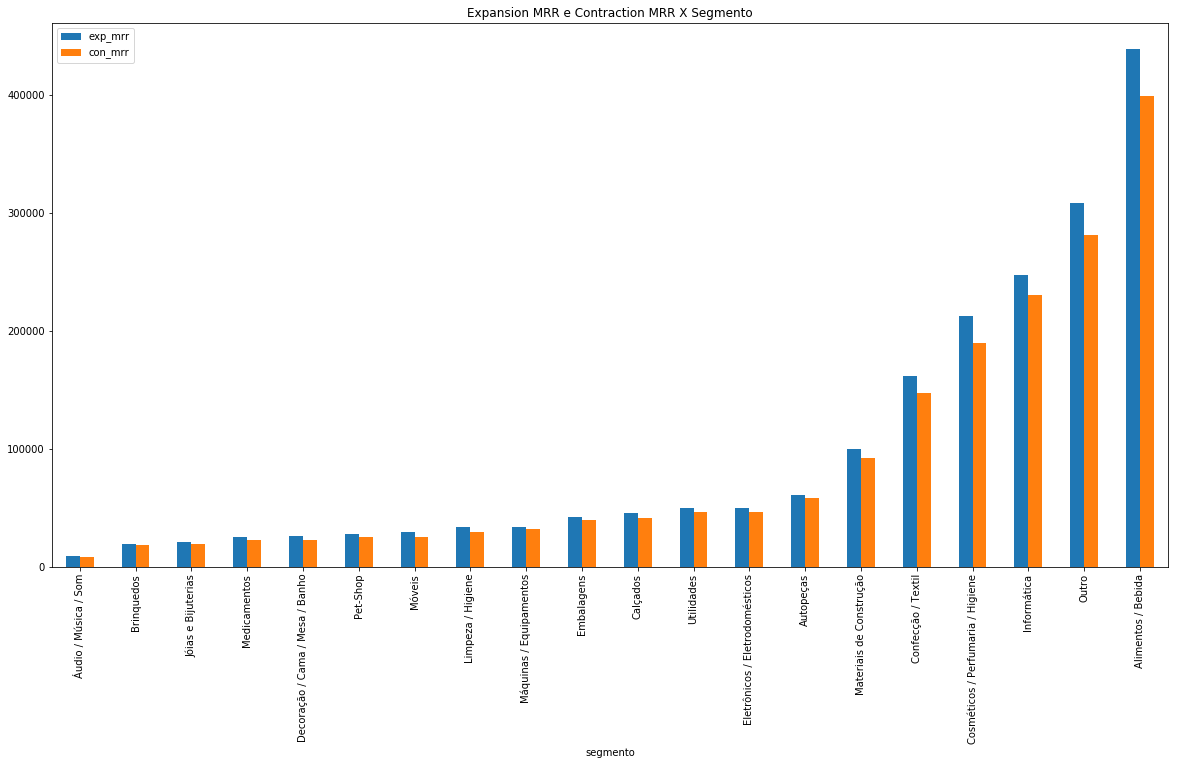

In [557]:
metricas_analises_df.groupby('segmento')['exp_mrr','con_mrr'].sum().sort_values(by='exp_mrr').plot(kind='bar',legend=True,title='Expansion MRR e Contraction MRR X Segmento')

Comparativo Resurrected MRR e Cancelled MRR ao longo dos meses

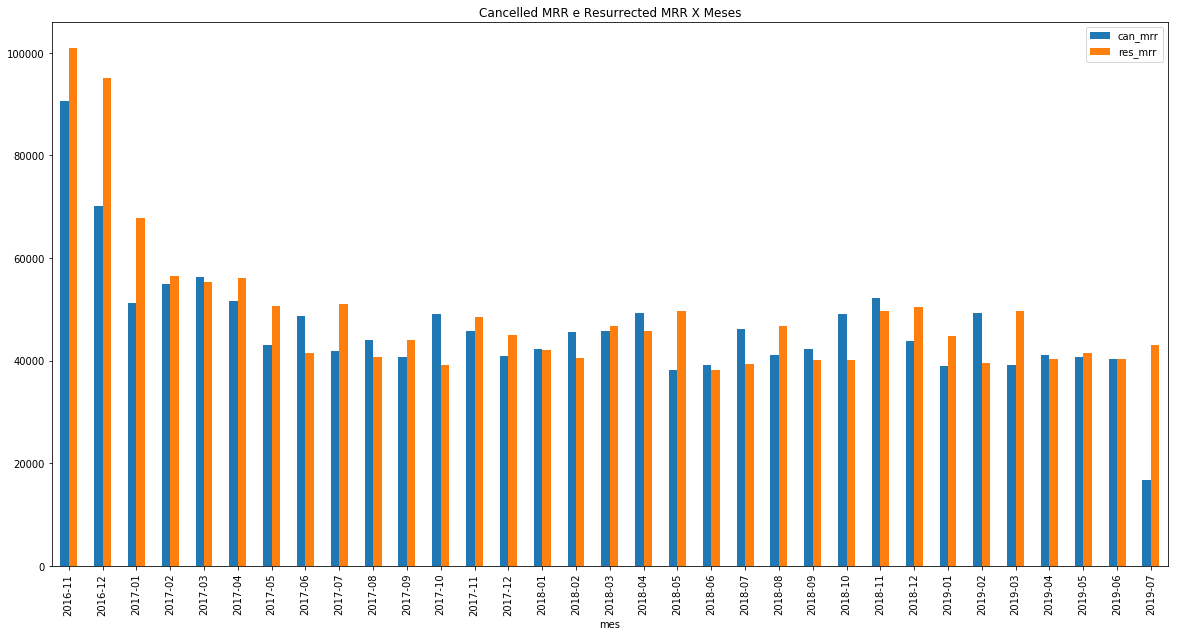

In [558]:
metricas_analises_df.groupby('mes')[['can_mrr','res_mrr']].sum().plot(kind='bar',legend=True,title='Cancelled MRR e Resurrected MRR X Meses')

Analisando os pagamentos do ultimo mes existente 

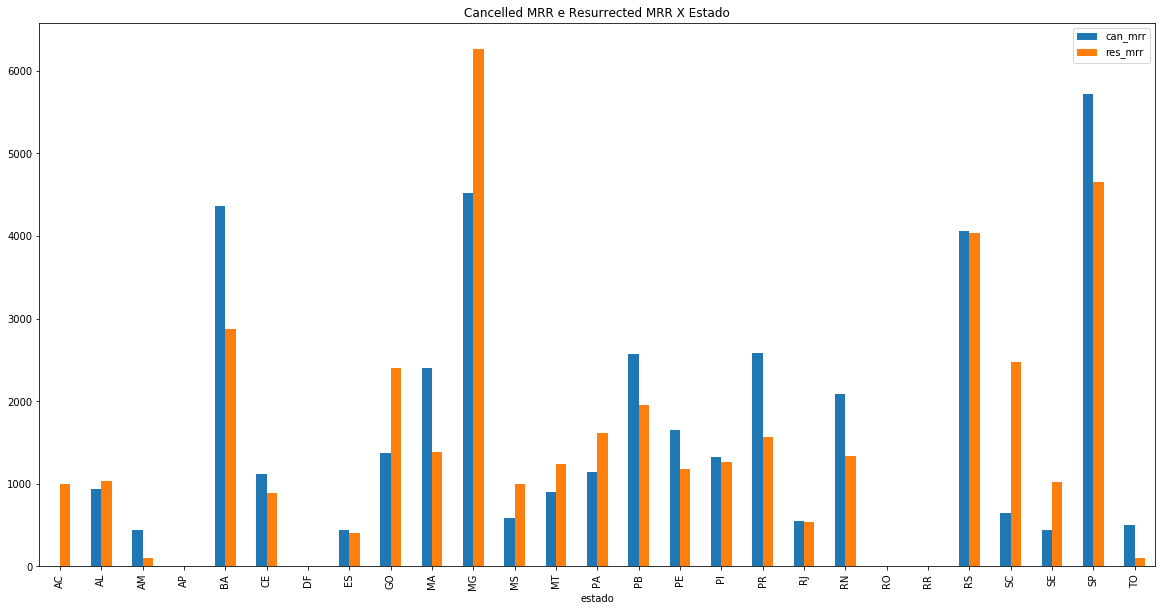

In [559]:
metricas_analises_df[metricas_analises_df['mes'] == "2019-06"].groupby('estado')['can_mrr','res_mrr'].sum().plot(kind='bar',legend=True,title='Cancelled MRR e Resurrected MRR X Estado')


Analisando os pagamentos do ultimo mes existente 

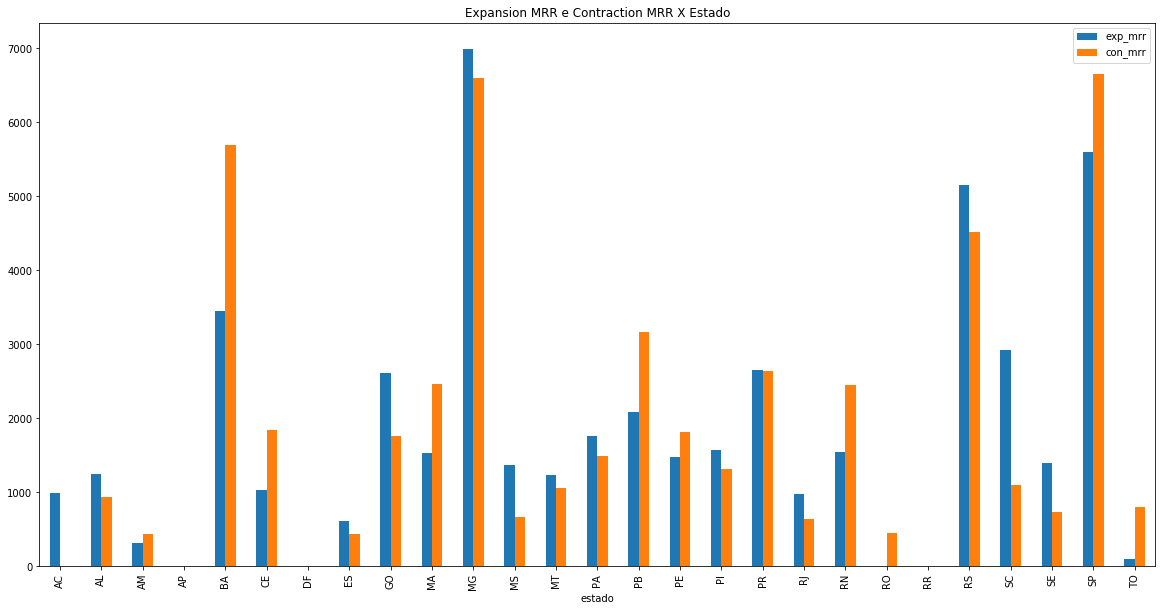

In [560]:
metricas_analises_df[metricas_analises_df['mes'] == "2019-06"].groupby('estado')['exp_mrr','con_mrr'].sum().plot(kind='bar',legend=True,title='Expansion MRR e Contraction MRR X Estado')


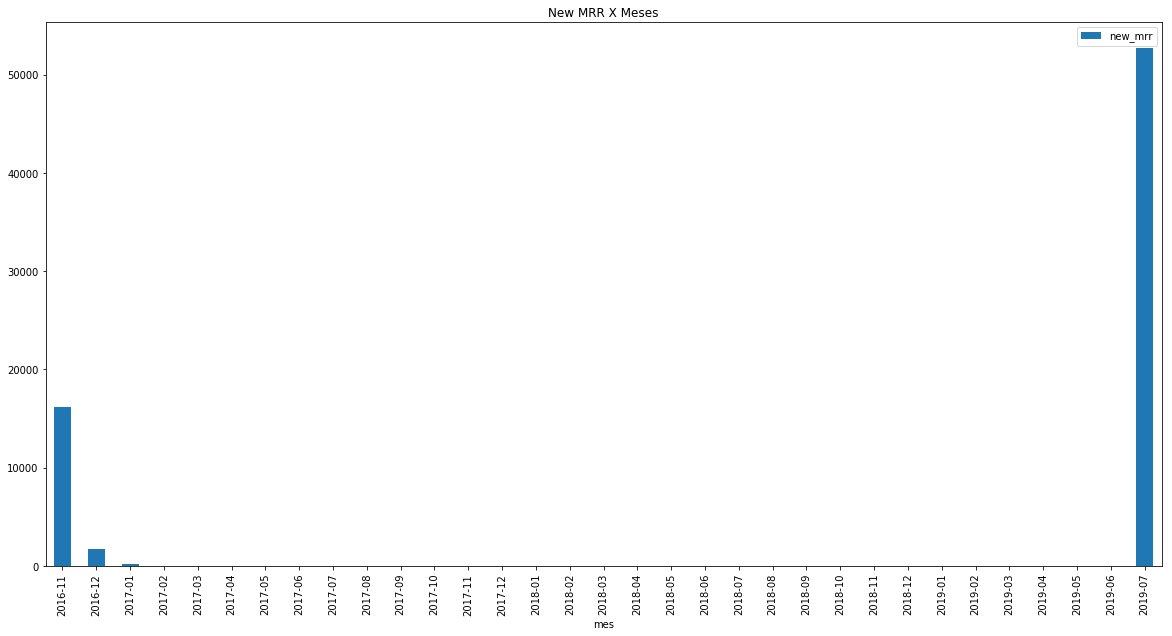

In [561]:
metricas_analises_df.groupby('mes')[['new_mrr']].sum().plot(kind='bar',legend=True,title='New MRR X Meses')

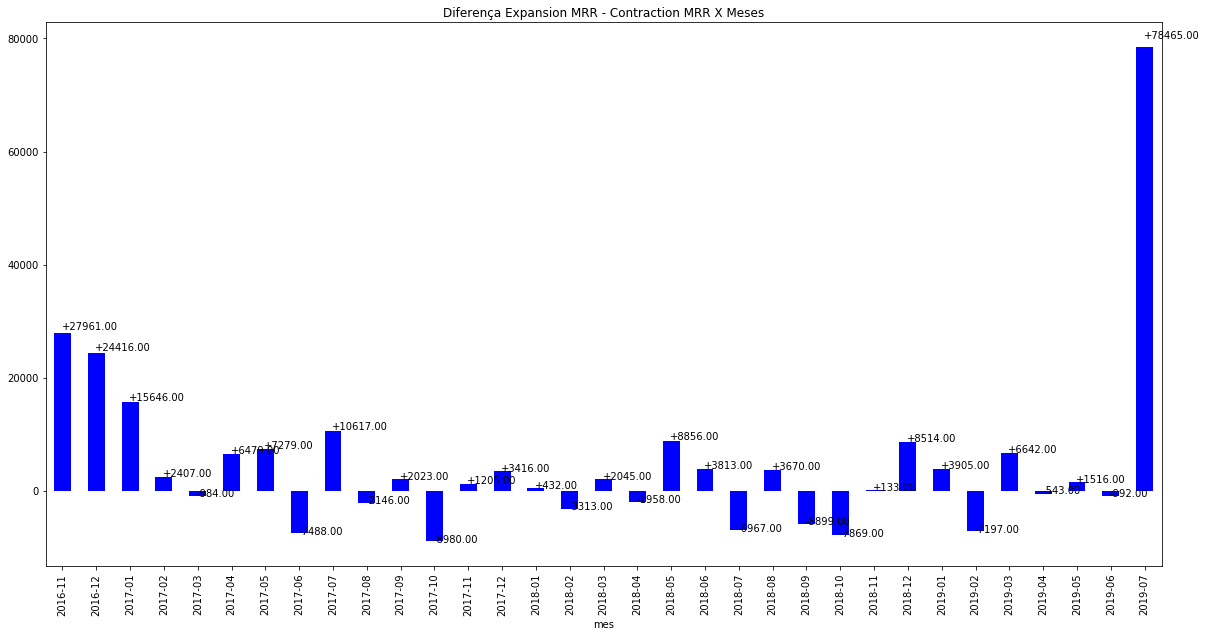

In [562]:
dif_exp_con  = metricas_analises_df[['mes','exp_mrr','con_mrr']].groupby('mes').sum()
df = (dif_exp_con['exp_mrr'] - dif_exp_con['con_mrr'])
ax = df.plot(kind='bar', color=['b'],title='Diferença Expansion MRR - Contraction MRR X Meses')
x_offset = -0.03
y_offset = 1.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)   
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 * y_offset))

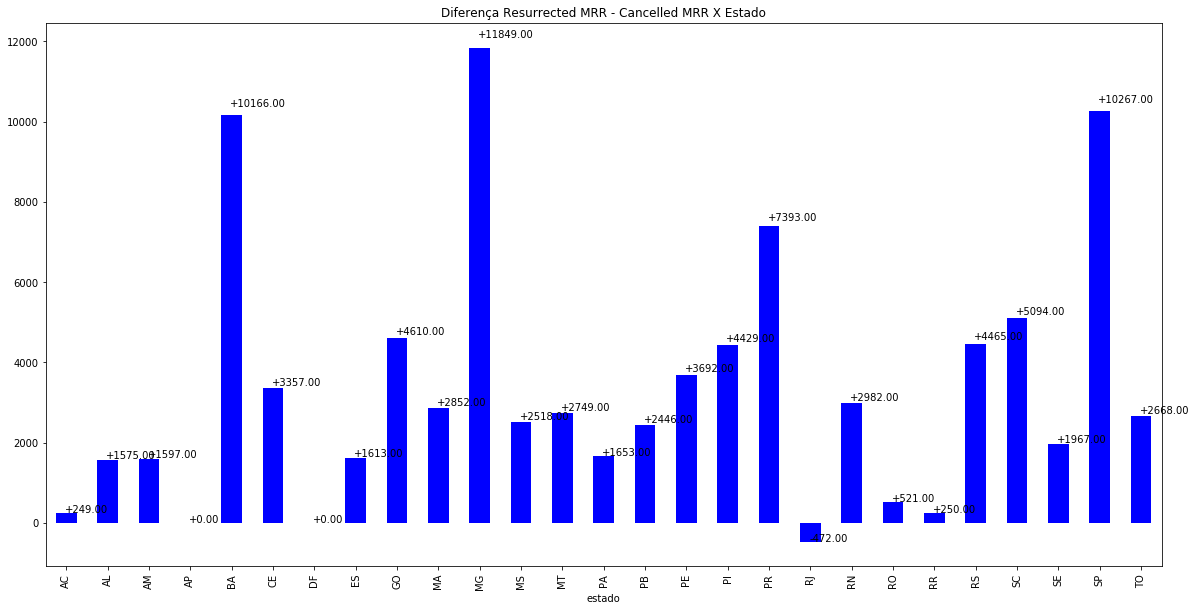

In [563]:
dif_can_res  = metricas_analises_df[['estado','can_mrr','res_mrr']].groupby('estado').sum()
df = dif_can_res['res_mrr'] - dif_can_res['can_mrr']
ax = df.plot(kind='bar', color=['b'],title='Diferença Resurrected MRR - Cancelled MRR X Estado') 
x_offset = -0.03
y_offset = 1.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)   
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 * y_offset))

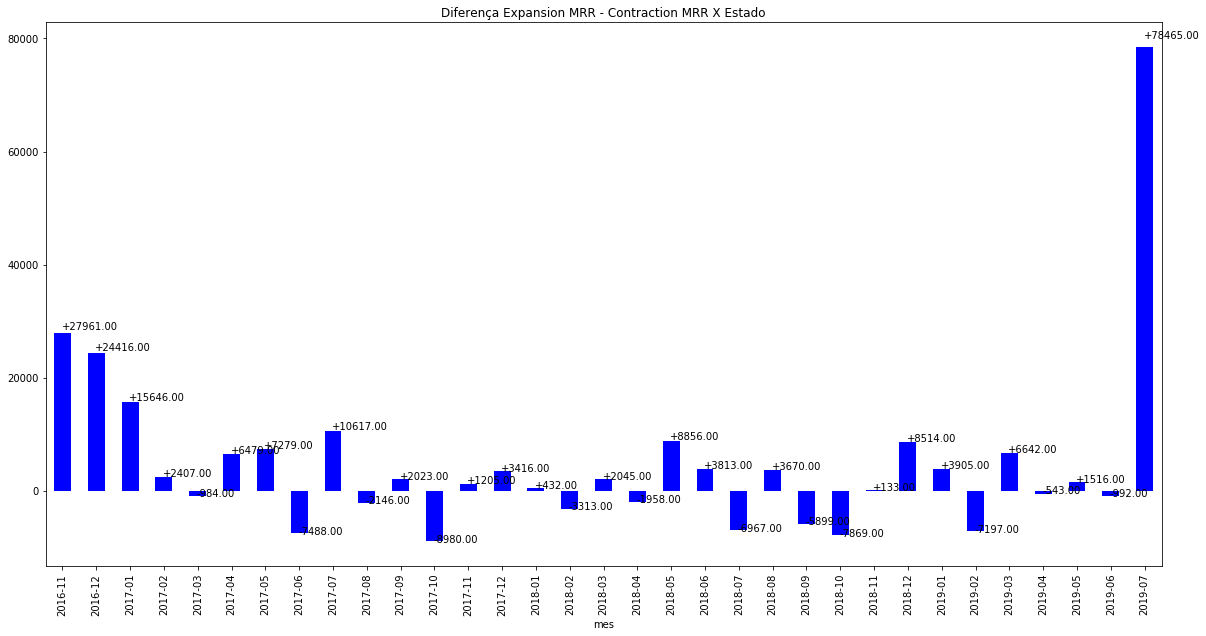

In [564]:
dif_can_res  = metricas_analises_df[['estado','exp_mrr','con_mrr']].groupby('estado').sum()
df = (dif_exp_con['exp_mrr'] - dif_exp_con['con_mrr'])
ax = df.plot(kind='bar', color=['b'],title='Diferença Expansion MRR - Contraction MRR X Estado') 
x_offset = -0.03
y_offset = 1.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)   
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 * y_offset))

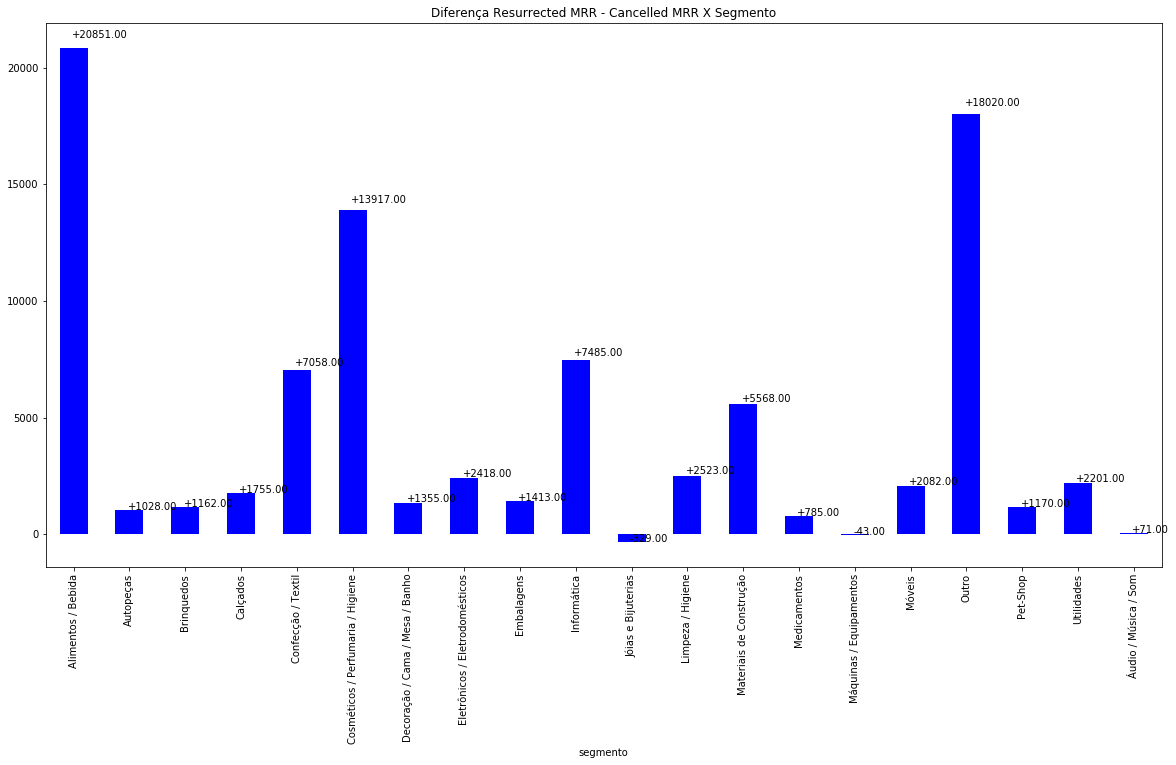

In [565]:
dif_can_res  = metricas_analises_df[['segmento','can_mrr','res_mrr']].groupby('segmento').sum()
df = dif_can_res['res_mrr'] - dif_can_res['can_mrr']
ax = df.plot(kind='bar', color=['b'],title='Diferença Resurrected MRR - Cancelled MRR X Segmento') 
x_offset = -0.03
y_offset = 1.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)   
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 * y_offset))

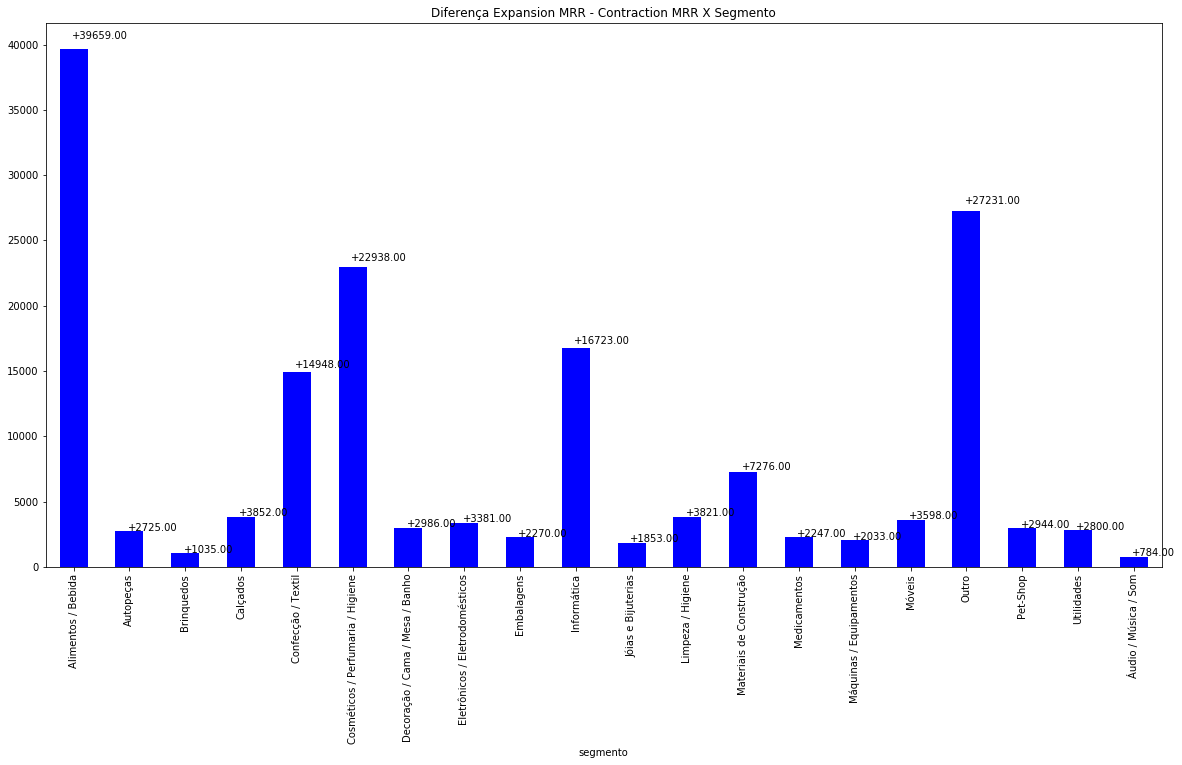

In [566]:
dif_exp_con  = metricas_analises_df[['segmento','exp_mrr','con_mrr']].groupby('segmento').sum()
df = (dif_exp_con['exp_mrr'] - dif_exp_con['con_mrr'])
ax = df.plot(kind='bar', color=['b'],title='Diferença Expansion MRR - Contraction MRR X Segmento') 
x_offset = -0.03
y_offset = 1.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format(b.y1 + b.y0)   
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 * y_offset))